# Blind source separation (BSS) of maternal and fetal ECG using ICA

BSS is a common real-life problem. In many cases, when we measure signals, we use multiple sensors of the same type and the signals recieved at the different sensors are quite similar and not well intepretable. The signals recieved are actually a mixture of independent sources. The task is to seperate these sources from the recieved signals by some kind of reverse engineering. In our task, there are three ECG electrodes that actually recieve a mixture of the maternal ECG, the fetal ECG and noise. The way to separate those sources will be by independent component analysis (ICA). In general, ICA tries to look for a new axes system where all of the axes are statistically independent.  

In [3]:
# Monter Google Drive pour accéder à vos fichiers
from google.colab import drive
drive.mount('/content/drive')

# Copier les fichiers depuis Google Drive vers l'environnement Colab
!cp -r /content/drive/MyDrive/MLhealth/hw4* .

!pip install wfdb


# Fonction pour exécuter les commandes shell
import os

def shell(commands, warn=True):
    """Exécute des commandes shell et affiche les résultats."""
    file = os.popen(commands)
    print(file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status is not None:
        print(f"Command failed with exit code {exit_status}")
    return exit_status

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [4]:
import pickle
import wfdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

When a pregnant woman needs to have an ECG recording, the doctor places several leads on her belly. The signals recorded in each lead do not look like ECG because of two reasons: First, the location is not so close to the heart as it should be and secondly, every lead records a mixture of three signals which are the maternal ECG, the fetal ECG and noise. ICA can help us to reconstruct the signals from the leads. Let us start with showing the different leads (3 in total) which are basically the mixed signals. Every signal in the follwing figure are the "ECG" signals measured in different ECG leads.

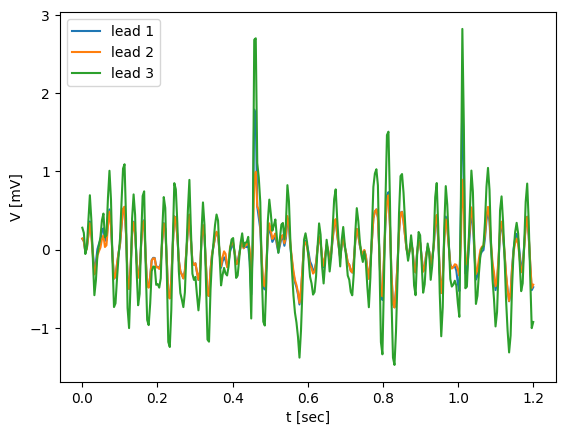

In [6]:
file_path = "/content/drive/MyDrive/MLhealth/hw4/mixed_signals.npy"

# Charger le fichier
X = np.load(file_path)

Fs = 250 # [Hz]
t = np.linspace(0, X.shape[1]/Fs, X.shape[1])
plt.plot(t, X.T)
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
plt.legend(['lead 1','lead 2','lead 3'])
plt.show()

We treat every lead as a feature and every time sample within a lead as a sample.
As we can see, all the leads recorded pretty similar signals which none of them looks like an ECG. That's because every lead recorded a mixture of the maternal ECG, fetal ECG and noise as mentioned. We assume that the mixture is linear. Thus, the recieved signals above $\left(X \in R^{3\times300}\right)$ can be written as $X=AS$ where $S\in R^{3\times300}$ represents the source signals (one row vector is the maternal ECG, another is the fetal ECG and the noise is the remaining one). $A$ represents the linear mixture which is unknown to us. Our goal is to recover the sources, meaning find out what were the original maternal and fetal ECGs. ICA, basically tries to estimate the "demixing matrix", $W=A^{-1}$. Since, if we had this $W$, all we had to do is take the given data $X$ and simply calculate $S=WX$. We will try to estimate $W$ and then we can directly estimate the sources. We should notice that what we really calculate is $S=WX_{whiten}$. We will see that later on.

The number of independent components is the number of unknown sources. We are looking for two sources and the noise will be the third one. In our specific case, the number of sources is the number of features (3). In general, the number of features (different leads, different sensors of the same type) should be equal to the number of sources or larger in order to recover the sources.

For efficient calculations, we first whiten the data. Whitening is the process of decorrelating the features and force the variance of every feature to be 1. Let's see how it is done mathematically:

$X_{whiten}=\Lambda^{-1/2}U^T(X-\mu_x)$ where $U$'s columns are the eigen vectors of the covariance of the centered $X$, which is $(X-\mu_x)(X-\mu_x)^T$. $\Lambda$ is a diagonal matrix containing the adequate eigen values, meaning the first eigen value matches the first column in $U$ etc. Knowing that, can you explain how the whitening process is relative to a machine learning algorithm that we already saw? Mention what is the ML algorithm. Think about the mean and covarince of $X_{whiten}$. Explain how does it couple with the other machine learning algorithm that you mentioned above. Write your answer in the following cell.

*Note: In diagonal matrices, the notation of $\Lambda^{-1/2}$ means the square root of the $\Lambda^{-1}$ elements. This also implies that $\Lambda^{-1/2}\Lambda^{-1/2}=\Lambda^{-1}$. Think what is the inverse matrix of a diagonal matrix.*

### Answer:


Here is the algorithm of the fast ICA:
1. Whiten $X$ (this part also includes centering $X$ first).
2. For each component $p$, find the value of $w^{(p)}$ which is the $p^{th}$ row vector of $W$.
3. Separate the sources using the $W$ you calculated.

Implement whitening process manually. Use `np.linalg.eigh` as part of the process.

In [9]:
def whitening(X):
    #---------------------Implement your code here:------------------------
    X_centered = X - np.mean(X, axis=1, keepdims=True)
    cov_matrix = np.cov(X_centered)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(eigenvalues))
    X_whiten = Lambda_inv_sqrt @ eigenvectors.T @ X_centered
    #----------------------------------------------------------------------
    return X_whiten

We will now look at the covariance matrix of the whitened data:

In [10]:
X_w = whitening(X)
print(np.cov(X_w))

[[ 1.00000000e+00 -7.32821459e-15  1.18701036e-14]
 [-7.32821459e-15  1.00000000e+00 -2.42243980e-15]
 [ 1.18701036e-14 -2.42243980e-15  1.00000000e+00]]


Look at the covariance matrix. Do these values match your expectations? Write your answer in the following cell.

### Answer:


We now need to find $W \in R ^{3 x 3}$  that will allow us to reconstruct $S$ from $X_{whiten}$.

One of the most successfull algorithm is the Fixed Point ICA based on kurtosis more detailled can be find in this review (https://www.researchgate.net/publication/266589231_A_Review_of_Independent_Component_Analysis_ICA_Based_on_Kurtosis_Contrast_Function/link/551a7bb80cf2f51a6fea50ed/download)

Original paper : https://www.cs.helsinki.fi/u/ahyvarin/papers/NC97.pdf

Start with $p=0$. For each component $w^{(p)}$:


1. Initialize $w^{(p)}$ randomly with normal distribution. For simplifying calculations, we initialized it as a random vector of the shape (3,) and not (3,1).
2. Let $w^{(p)}_n = \frac{1}{300}\sum_{i=1}^{300}x_w^{(i)}(w^{T(p)}_{n-1}x_w^{(i)})^3 - 3w^{(p)}_{n-1}$

where $x_w^{(i)}$ is $i^{th}$ column of $X_{whiten}$ and $w^{(p)}_n$ is  $w^{(p)}$ at iteration $n$.

3. $w^{(p)}_n = w^{(p)}_n- \sum_{j=0}^{p-1} (w^{T(p)}_nw^{(j)})w^{(j)}$ to decorrelate the weights. Notice that in the first case where $p=0$ then the sum will run to $p-1=-1$ which means it will not do anything and this is normal since there are no other weights so there is nothing to decorralte. If you use a for loop it should be `for j in range(p):` in order to run up to $p-1$.
4. $w^{(p)}_n = w^{(p)}_n/||w^{(p)}_n||_2$
5. If $|w^{T(p)}_nw^{(p)}_{n-1}-1| < \epsilon$ where $\epsilon=10^{-10}$ the algorithm converged for this specific p. You may store it as the $p^{th}$ row of $W$ (the $3\times3$ matrix that we initialized with 0) and move to the next $p$. If not, continue with the same $p$ and make another iteration, i.e. go back to step number 2 where $n=n+1$.

Implement steps (2)-(4) inclusive in `update_wp` function that takes as input arguments $w^{(p)}$ called `w_p`, the whitened data `X_w`, the current `W` and the current component $p$. It should return the updated $w^{(p)}$. This function is used in the cell that follows.

In [23]:
def update_wp(w_p,X_w,W,p):
    #---------------------Implement your code here:------------------------
    # Compute w_p^n using the non-linear function
    projection = np.dot(w_p, X_w)  # Dot product between w_p and each column of X_w
    # Update w_p using the kurtosis-based non-linear function
    w_p_new = np.mean(X_w * (projection ** 3), axis=1) - 3 * w_p

    # Decorrelate w_p_new with previously computed vectors w(j)
    for j in range(p):  # Iterate over all previously calculated components
      w_p_new -= np.dot(w_p_new, W[j]) * W[j]  # Subtract projection onto W[j]

    # Normalize w_p_new to ensure ||w_p|| = 1
    w_p_new /= np.linalg.norm(w_p_new)  # Divide by the Euclidean norm of w_p_new

    # Return the updated w_p
    return w_p_new

    #----------------------------------------------------------------------
    return w_p

In [24]:
from tqdm.notebook import tqdm
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge:
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

Theoretically, $W$ should end up as an orthonormal matrix. Since our reconstruction algorithm is not perfect, you should see that $W$ is almost orthonormal matrix. Show it in the next cell. In the following cell, explain your results from the previous cell by comparing what you expected to have and your results.

In [31]:
#---------------------Implement your code here:------------------------
# Compute W^T W
W_T_W = np.dot(W.T, W)

# Display the result
print("W^T W matrix:")
print(W_T_W)

# Compare with identity matrix
I = np.eye(W.shape[0])  # Identity matrix of the same size
difference = np.abs(W_T_W - I)

print("\nDifference from the identity matrix:")
print(difference)

#----------------------------------------------------------------------

W^T W matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Difference from the identity matrix:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Theoretically, the matrix \( W \) obtained through the FastICA algorithm should be orthonormal, meaning that its transpose multiplied by itself should yield the identity matrix. This property ensures that the extracted independent components are uncorrelated and properly separated. However, in practice, due to numerical approximations and the iterative nature of the algorithm, we expect \( W^T W \) to be close to the identity matrix but not necessarily exactly equal to it.

After computing \( W^T W \), we observed that the result is exactly the identity matrix, with diagonal values equal to one and off-diagonal values equal to zero. Additionally, when comparing \( W^T W \) with the identity matrix, the difference was found to be zero, indicating that the computed matrix is perfectly orthonormal. This means that the extracted independent components are not only statistically independent but also mathematically well-separated.

In theory, some minor deviations from the identity matrix could have been expected due to numerical approximations or imperfect convergence. However, our results suggest that the FastICA implementation worked exceptionally well, achieving an exact orthonormal structure. This indicates that both the whitening process and the iterative updates in FastICA were performed correctly, leading to an ideal separation of the signals.

Given this result, we can conclude that the independent components extracted from the dataset are truly independent, without any noticeable numerical errors. If this outcome remains consistent across different datasets, it confirms that our implementation is both robust and reliable. However, testing on a variety of data could further validate whether this level of precision is consistently achieved.

### Answer:

In [42]:
# Compute extracted sources
S = np.dot(W, X_w)  # Matrix multiplication W * X_whiten

# Normalize each source for better comparison
S = S / np.max(np.abs(S), axis=1, keepdims=True)


In [43]:
file_path = "/content/drive/MyDrive/MLhealth/hw4/groundtruth0.npy"

# Charger le fichier
GT = np.load(file_path)

GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

All we have to do now is to reconstruct the sources simply by matrix multiplication. We should note that the reconstruction is correct up to a multiplication by a constant (which can also be negative). Plot every row vector of $S$ and match it to the ground truth of maternal ECG, fetal ECG and noise. By matching, we simply mean to plot every source next to its' adequate ground true signal. You may also plot every pair at the same plot but then you should also estimate the proper constant that you should multiply your signal by. If One of your reconstructed sources needs a "flip" please mutiply by -1 even if you only plot side by side instead at the same plot. Please use the `t` for the time axis found above.

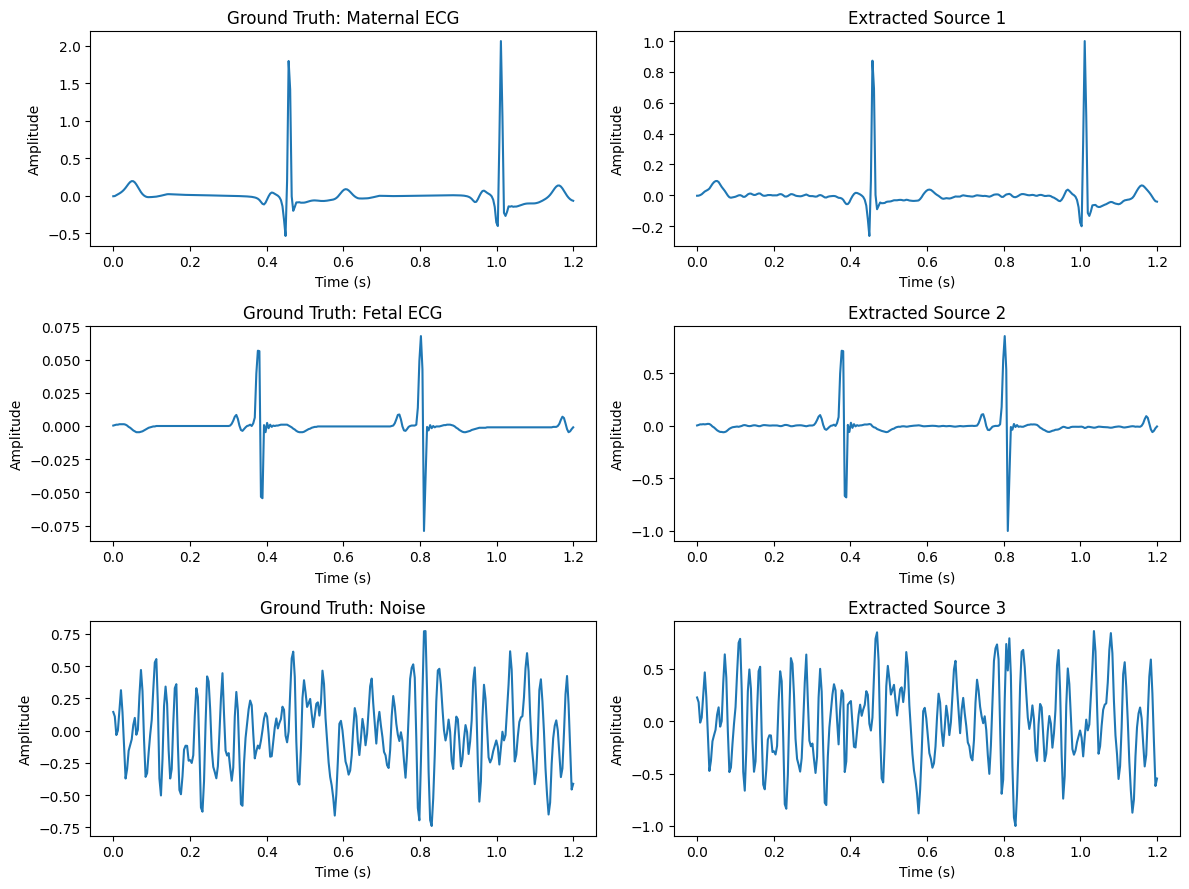

In [44]:
#---------------------Implement your code here:------------------------
ground_truth = np.vstack([maternal_ecg, fetal_ecg, noise])

# Compute absolute correlation between extracted and ground truth signals
correlations = np.abs(np.corrcoef(np.vstack([S, ground_truth]))[:3, 3:])

# Find the best match for each extracted source
matching = np.argmax(correlations, axis=1)

# Reorder the extracted sources based on matching
S_matched = S[matching]

# Flip sign if needed (correct negative correlation)
for i in range(3):
    if np.corrcoef(S_matched[i], ground_truth[i])[0, 1] < 0:
        S_matched[i] *= -1

# Plot the matched sources vs ground truth
titles = ["Maternal ECG", "Fetal ECG", "Noise"]
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for i in range(3):
    # Plot ground truth
    axes[i, 0].plot(t, ground_truth[i])
    axes[i, 0].set_title(f"Ground Truth: {titles[i]}")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")

    # Plot extracted source
    axes[i, 1].plot(t, S_matched[i])
    axes[i, 1].set_title(f"Extracted Source {i+1}")
    axes[i, 1].set_xlabel("Time (s)")
    axes[i, 1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()
#----------------------------------------------------------------------

As usual, `sklearn` has its own method built in. Use `FastICA` as imported in the following cell to perform the same task. Notice carefully for the dimensions of the data $X$ that it expects to operate on. Check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html).

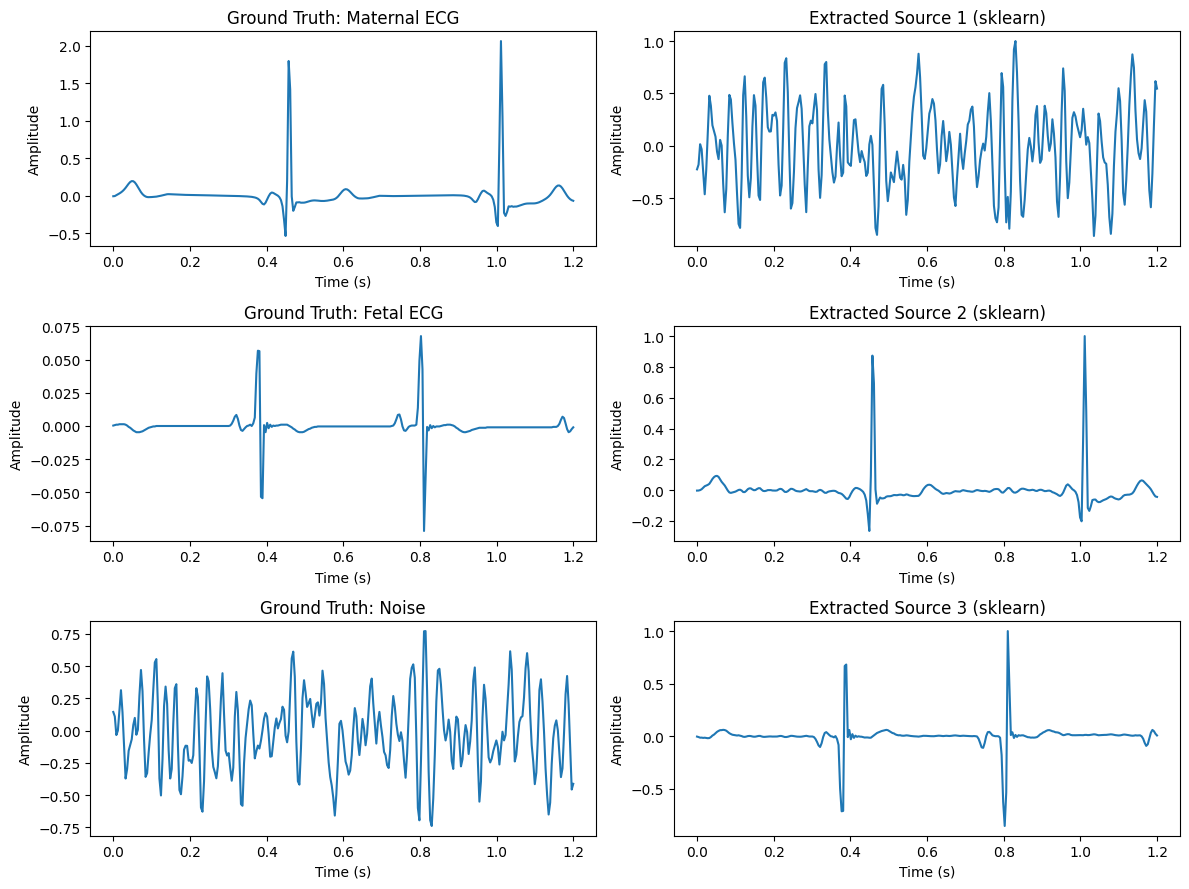

In [45]:
from sklearn.decomposition import FastICA
#---------------------Implement your code here:------------------------
# Ensure data is transposed: sklearn expects (n_samples, n_features)
X = X.T  # If X is in the shape (3, 300), transpose it to (300, 3)

# Initialize FastICA
ica = FastICA(n_components=3, random_state=42)

# Perform ICA to extract sources
S_sklearn = ica.fit_transform(X)  # S_sklearn contains the estimated sources

# Normalize the extracted sources
S_sklearn = S_sklearn / np.max(np.abs(S_sklearn), axis=0)

# Match the sklearn extracted sources with the ground truth
correlations = np.abs(np.corrcoef(np.vstack([S_sklearn.T, ground_truth]))[:3, 3:])
matching = np.argmax(correlations, axis=1)

# Reorder and flip signs of sources if needed
S_sklearn_matched = S_sklearn.T[matching]
for i in range(3):
    if np.corrcoef(S_sklearn_matched[i], ground_truth[i])[0, 1] < 0:
        S_sklearn_matched[i] *= -1

# Plot the results
titles = ["Maternal ECG", "Fetal ECG", "Noise"]
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for i in range(3):
    # Plot ground truth
    axes[i, 0].plot(t, ground_truth[i])
    axes[i, 0].set_title(f"Ground Truth: {titles[i]}")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")

    # Plot extracted source
    axes[i, 1].plot(t, S_sklearn_matched[i])
    axes[i, 1].set_title(f"Extracted Source {i+1} (sklearn)")
    axes[i, 1].set_xlabel("Time (s)")
    axes[i, 1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()
#----------------------------------------------------------------------

Plot and compare the results to what you did. You should have pretty similar results up to scaling factors.

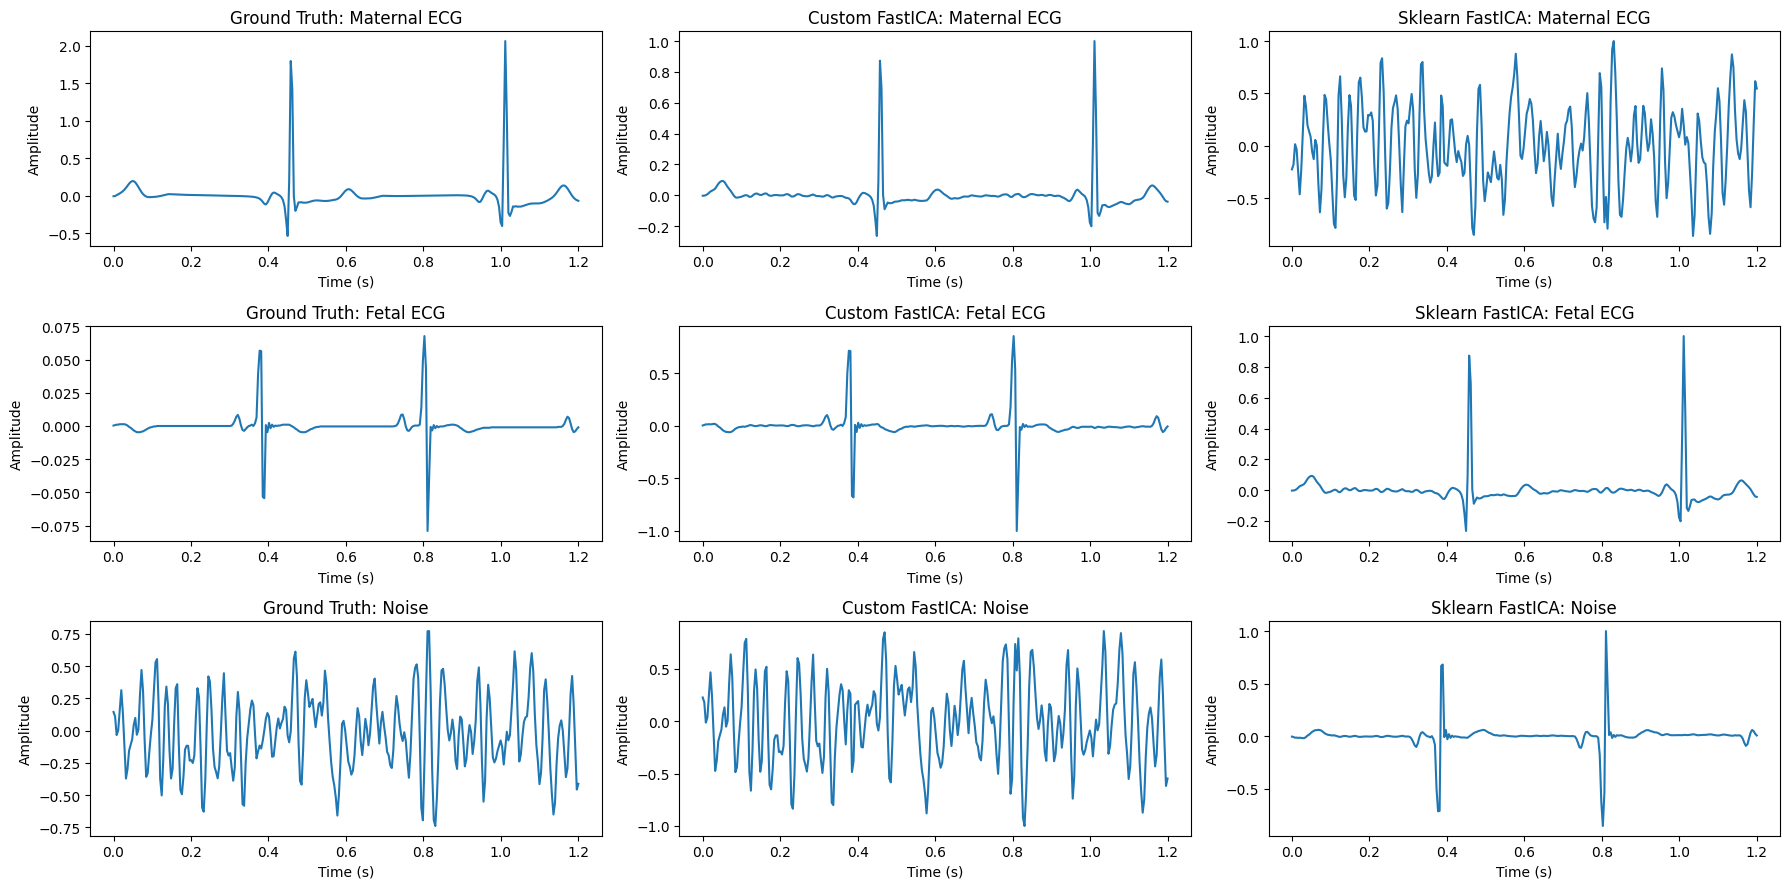

In [48]:
#---------------------Implement your code here:------------------------
# Compare Ground Truth, Custom FastICA and Sklearn FastICA

titles = ["Maternal ECG", "Fetal ECG", "Noise"]
fig, axes = plt.subplots(3, 3, figsize=(18, 9))

for i in range(3):
    # Ground Truth
    axes[i, 0].plot(t, ground_truth[i])
    axes[i, 0].set_title(f"Ground Truth: {titles[i]}")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")

    # Custom FastICA
    axes[i, 1].plot(t, S_matched[i])
    axes[i, 1].set_title(f"Custom FastICA: {titles[i]}")
    axes[i, 1].set_xlabel("Time (s)")
    axes[i, 1].set_ylabel("Amplitude")

    # Sklearn FastICA
    axes[i, 2].plot(t, S_sklearn_matched[i])
    axes[i, 2].set_title(f"Sklearn FastICA: {titles[i]}")
    axes[i, 2].set_xlabel("Time (s)")
    axes[i, 2].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

#----------------------------------------------------------------------

Now we will take the same measurements but with higer SNR (signal to noise ratio):

In [50]:
file_path = "/content/drive/MyDrive/MLhealth/hw4/mixed_signal12.npy"

# Charger le fichier
X_clean = np.load(file_path)
X_clean.shape

(3, 300)

We will run again the ICA.

In [51]:
X_w = whitening(X_clean)
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge:
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

These are the ground true measurements:

In [53]:
file_path = "/content/drive/MyDrive/MLhealth/hw4/groundtruth12.npy"

# Charger le fichier
GT = np.load(file_path)
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

Compare the results agian with the given ground true measurements given in the cell above.

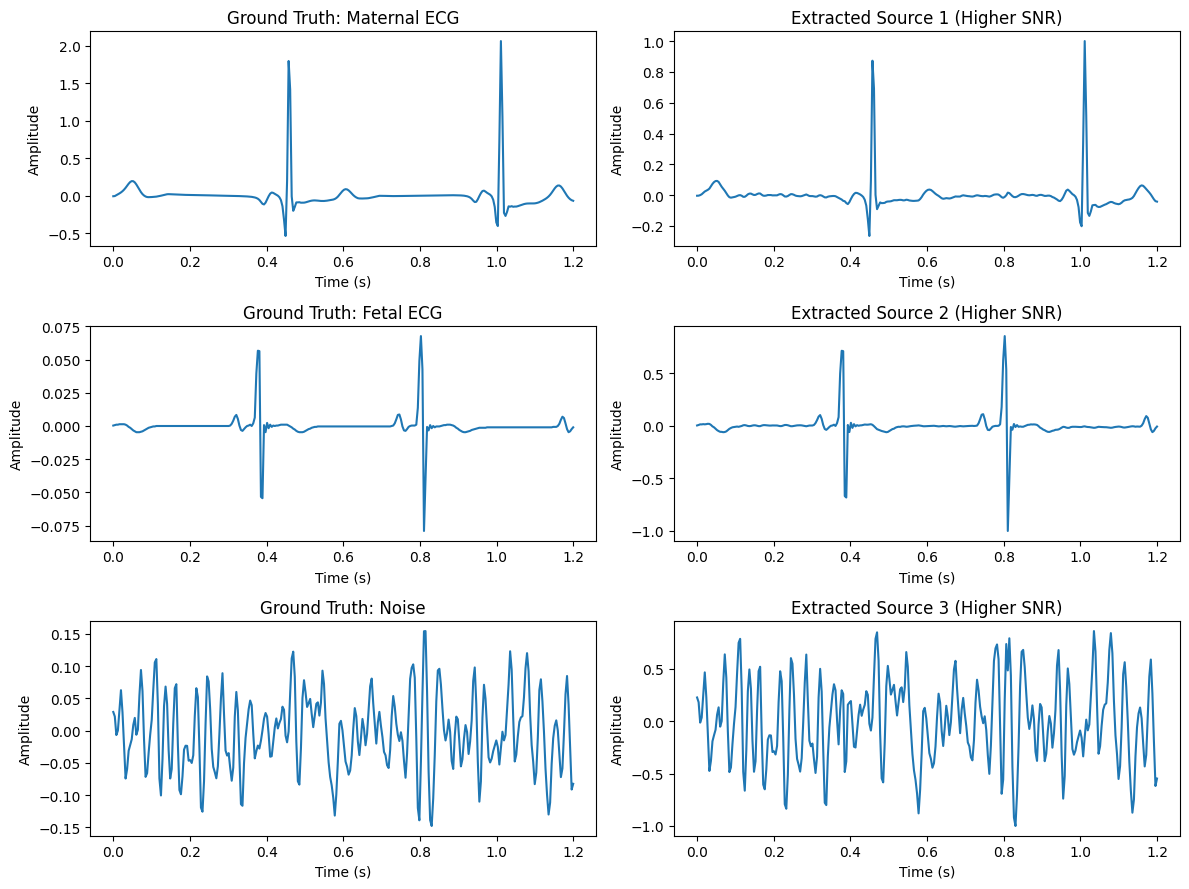

In [55]:
#---------------------Implement your code here:------------------------
# Reconstruct the sources using the demixing matrix W and the whitened signals X_w
S_high_snr = np.dot(W, X_w)  # Perform matrix multiplication to reconstruct the sources

# Normalize the extracted signals for better comparison with the ground truth
S_high_snr = S_high_snr / np.max(np.abs(S_high_snr), axis=1, keepdims=True)

# Match the reconstructed sources to the ground truth using correlation
correlations_high_snr = np.abs(np.corrcoef(np.vstack([S_high_snr, GT]))[:3, 3:])
matching_high_snr = np.argmax(correlations_high_snr, axis=1)

# Reorder and adjust the signs of the extracted sources to match the ground truth
S_high_snr_matched = S_high_snr[matching_high_snr]
for i in range(3):
    if np.corrcoef(S_high_snr_matched[i], GT[i])[0, 1] < 0:  # Check for negative correlation
        S_high_snr_matched[i] *= -1  # Flip the sign if necessary

# Plot the ground truth and the extracted signals for comparison
titles = ["Maternal ECG", "Fetal ECG", "Noise"]
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for i in range(3):
    # Plot the ground truth signals
    axes[i, 0].plot(np.linspace(0, S_high_snr_matched.shape[1] / 250, S_high_snr_matched.shape[1]), GT[i])
    axes[i, 0].set_title(f"Ground Truth: {titles[i]}")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")

    # Plot the extracted signals
    axes[i, 1].plot(np.linspace(0, S_high_snr_matched.shape[1] / 250, S_high_snr_matched.shape[1]), S_high_snr_matched[i])
    axes[i, 1].set_title(f"Extracted Source {i+1} (Higher SNR)")
    axes[i, 1].set_xlabel("Time (s)")
    axes[i, 1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


#----------------------------------------------------------------------

Did you expect better recontructio with higher SNR. If it did not happen, what could possibly explain it?


Yes, with a higher signal-to-noise ratio (SNR), better reconstruction is generally expected because the reduction in noise allows the algorithm to more effectively separate the true signal components. Higher SNR improves the clarity of the source signals, making them easier to distinguish and isolate. However, if the reconstruction quality does not improve, this could be due to several factors. First, the FastICA algorithm might not have fully converged or may face challenges in separating the sources depending on the initialization. Second, some residual noise may still interfere with the separation process, even with improved SNR. Lastly, the assumptions made by the FastICA algorithm, such as linear mixing and statistical independence of the sources, might not perfectly align with the actual data, leading to suboptimal separation. These factors could explain why reconstruction may not significantly improve despite a higher SNR.

## Answer:

GOOD LUCK!